## Notebook 1: 


In [1]:
### Notebook 1
### Data set 1 (Viburnum)
### Language: Bash
### Data Location: NCBI SRA PRJNA299402 & PRJNA299407

In [3]:
%%bash
## make a new directory for this analysis
mkdir -p empirical_1/
mkdir -p empirical_1/halfrun
mkdir -p empirical_1/fullrun

In [87]:
## import Python libraries
import pandas as pd
import numpy as np
import ipyparallel
import urllib2
import glob
import os

### Download the sequence data
Sequence data for this study is archived on the NCBI sequence read archive (SRA). The data were run in two separate Illumina runs, but are combined under a single project id number.  

+ Project SRA: SRP055977
+ Project number: PRJNA277574
+ Biosample numbers: SAMN03394519 -- SAMN03394561
+ Runs: SRR1915524 -- SRR1915566  
+ The barcodes file is in the github repository for this [project]().  

The library contains 95 samples. We uploaded the two demultiplexed samples for each individual separately, so each sample has 2 files. Below we examine just the first library (the "half" data set) and then both libraries combined (the "full" data set). We analyze on 64 samples since the remaining samples are replicate individuals within species that are part of a separate project. 

You can download the data set using the script below:

In [ ]:
%%bash
## get the data from Dryad
for run in $(seq 24 28);

  do
wget -q -r -nH --cut-dirs=9 \
ftp://ftp-trace.ncbi.nlm.nih.gov/\
sra/sra-instant/reads/ByRun/sra/SRR/\
SRR191/SRR19155$run/SRR19155$run".sra";

done

In [ ]:
%%bash
## convert sra files to fastq using fastq-dump tool
fastq-dump *.sra

In [ ]:
## IPython code

## This reads in a table mapping sample names to SRA numbers
## that is hosted on github

## open table from github url
url = "https://raw.githubusercontent.com/"+\
      "dereneaton/virentes/master/SraRunTable.txt"
intable = urllib2.urlopen(url)

## make name xfer dictionary
DF = pd.read_table(intable, sep="\t")
D = {DF.Run_s[i]:DF.Library_Name_s[i] for i in DF.index}

## change file names and move to fastq dir/
for fname in glob.glob("*.fastq"):
    os.rename(fname, "analysis_pyrad/fastq/"+\
                     D[fname.replace(".fastq",".fq")])

### Create a set with reads concatenated from both technical replicates of each sample

In [1]:
%%bash
mkdir -p fastq_combined

In [26]:
## IPython code that makes a bash call w/ (!)
## get all the data from the two libraries and concatenate it
lib1tax = glob.glob("/home/deren/Documents/Vib_Lib1/fastq_Lib1/*.gz")
lib2tax = glob.glob("/home/deren/Documents/Vib_Lib1/fastq_Lib2/*.gz")

## names had to be modified to match
taxa = [i.split("/")[-1].split("_", 1)[1] for i in lib1tax]

for tax in taxa:
    ! cat /home/deren/Documents/Vib_Lib1/fastq_Lib1/Lib1_$tax \
          /home/deren/Documents/Vib_Lib1/fastq_Lib2/Lib2_$tax \
          > /home/deren/Documents/Vib_Lib1/fastq_combined/$tax 

cat: /home/deren/Documents/Vib_Lib1/fastq_Lib2/Lib2_lantan_combined_R1_.gz: No such file or directory
cat: /home/deren/Documents/Vib_Lib1/fastq_Lib2/Lib2_propiinquum_combined_R1_.gz: No such file or directory


## Make a params file

In [4]:
%%bash
pyrad --version

pyRAD 3.0.63


In [5]:
%%bash
## create a new default params file
rm params.txt
pyrad -n 

	new params.txt file created


In [156]:
%%bash
## substitute new parameters into file
sed -i '/## 1. /c\empirical_1/halfrun    ## 1. working directory ' params.txt
sed -i '/## 6. /c\TGCAG                  ## 6. cutters ' params.txt
sed -i '/## 7. /c\30                     ## 7. N processors      ' params.txt
sed -i '/## 9. /c\6                      ## 9. NQual             ' params.txt
sed -i '/## 10./c\.85                    ## 10. clust threshold  ' params.txt
sed -i '/## 12./c\4                      ## 12. MinCov           ' params.txt
sed -i '/## 13./c\10                     ## 13. maxSH            ' params.txt
sed -i '/## 14./c\empirical_1_half_m4    ## 14. output name      ' params.txt
sed -i '/## 18./c\/home/deren/Documents/Vib_Lib1/fastq_Lib1/*.fastq ## 18. data location    ' params.txt
sed -i '/## 29./c\2,2                    ## 29. trim overhang    ' params.txt
sed -i '/## 30./c\p,n,s,a                ## 30. output formats   ' params.txt

In [157]:
cat params.txt

==** parameter inputs for pyRAD version 3.0.63  **======================== affected step ==
empirical_1/halfrun    ## 1. working directory 
./*.fastq.gz              ## 2. Loc. of non-demultiplexed files (if not line 18)  (s1)
./*.barcodes              ## 3. Loc. of barcode file (if not line 18)             (s1)
vsearch                   ## 4. command (or path) to call vsearch (or usearch)    (s3,s6)
muscle                    ## 5. command (or path) to call muscle                  (s3,s7)
TGCAG                  ## 6. cutters 
30                     ## 7. N processors      
6                         ## 8. Mindepth: min coverage for a cluster              (s4,s5)
6                      ## 9. NQual             
.85                    ## 10. clust threshold  
rad                       ## 11. Datatype: rad,gbs,pairgbs,pairddrad,(others:see docs)(all)
4                      ## 12. MinCov           
10                     ## 13. maxSH            
empirical_1_half_m4    ## 14. output name     

In [ ]:
%%bash
pyrad -p params.txt -s 234567 >> log.txt 2>&1  

In [53]:
%%bash
sed -i '/## 12./c\2                         ## 12. MinCov           ' params.txt
sed -i '/## 14./c\empirical_1_half_m2       ## 14. output name      ' params.txt

In [35]:
%%bash
pyrad -p params.txt -s 7 >> log.txt 2>&1  

### Assemble the full data set
Added the 'a' option to output formats to build an ".alleles" file which will be used later for mrbayes/bucky analyses. 

In [141]:
%%bash
## substitute new parameters into file
sed -i '/## 1. /c\empirical_1/fullrun    ## 1. working directory ' params.txt
sed -i '/## 6. /c\TGCAG                  ## 6. cutters ' params.txt
sed -i '/## 7. /c\30                     ## 7. N processors      ' params.txt
sed -i '/## 9. /c\6                      ## 9. NQual             ' params.txt
sed -i '/## 10./c\.85                    ## 10. clust threshold  ' params.txt
sed -i '/## 12./c\4                      ## 12. MinCov           ' params.txt
sed -i '/## 13./c\10                     ## 13. maxSH            ' params.txt
sed -i '/## 14./c\empirical_1_full_m4    ## 14. output name      ' params.txt
sed -i '/## 18./c\/home/deren/Documents/Vib_Lib1/fastq_combined/*.fastq ## 18. data location    ' params.txt
sed -i '/## 29./c\2,2                    ## 29. trim overhang    ' params.txt
sed -i '/## 30./c\p,n,s,a                ## 30. output formats   ' params.txt

In [ ]:
%%bash
pyrad -p params.txt -s 234567 >> log.txt 2>&1  

In [49]:
%%bash
sed -i '/## 12./c\2                         ## 12. MinCov           ' params.txt
sed -i '/## 14./c\empirical_1_full_m2       ## 14. output name      ' params.txt

In [142]:
%%bash
pyrad -p params.txt -s 7 >> log.txt 2>&1  

## Results
We are interested in the relationship between the amount of input (raw) data between any two samples, the average coverage they recover when clustered together, and the phylogenetic distances separating samples.  

### Raw data amounts (1 sequence lane)
The average number of raw reads per sample is 1.37M.

In [3]:
## read in the data
s2dat = pd.read_table("empirical_1/halfrun/stats/s2.rawedit.txt", header=0, nrows=66)

## print summary stats
print s2dat["passed.total"].describe()

## find which sample has the most raw data
maxraw = s2dat["passed.total"].max()
print "\nmost raw data in sample:"
print s2dat['sample '][s2dat['passed.total']==maxraw]

count         65.000000
mean     1372359.907692
std       640115.353508
min       324478.000000
25%       961366.000000
50%      1249609.000000
75%      1602036.000000
max      3113934.000000
Name: passed.total, dtype: float64

most raw data in sample:
54    Lib1_sulcatum_D9_MEX_003
Name: sample , dtype: object


### Raw data amounts (2 sequence lanes)
The average nreads now is 2.74M

In [4]:
## read in the data
s2dat = pd.read_table("empirical_1/fullrun/stats/s2.rawedit.txt", header=0, nrows=66)

## print summary stats
print s2dat["passed.total"].describe()

## find which sample has the most raw data
maxraw = s2dat["passed.total"].max()
print "\nmost raw data in sample:"
print s2dat['sample '][s2dat['passed.total']==maxraw]

count         65.000000
mean     2736777.215385
std      1262460.162891
min       643550.000000
25%      1918460.000000
50%      2519904.000000
75%      3215483.000000
max      6183790.000000
Name: passed.total, dtype: float64

most raw data in sample:
20    foetidum_D24_KFC_1942
Name: sample , dtype: object


### Look at distributions of coverage
pyrad v.3.0.63 outputs depth information for each sample which I read in here and plot. First let's ask which sample has the highest depth of coverage. The std here is the std in means across samples. The std of depths within individuals is much higher.

In [33]:
## read in the s3 results
s3dat = pd.read_table("empirical_1/halfrun/stats/s3.clusters.txt", header=0, nrows=66)

## print summary stats
print "summary of means\n=================="
print s3dat['dpt.me'].describe()

## print summary stats
print "\nsummary of std\n=================="
print s3dat['dpt.sd'].describe()

## print summary stats
print "\nsummary of proportion lowdepth\n=================="
print pd.Series(1-s3dat['d>5.tot']/s3dat["total"]).describe()

## find which sample has the greatest depth of retained loci
maxdepth = s3dat["d>5.tot"].max()
print "\nhighest coverage in sample:"
print s3dat['taxa'][s3dat['d>5.tot']==maxdepth]

summary of means
count    65.000000
mean     14.869446
std       3.033109
min      10.008000
25%      12.912000
50%      14.197000
75%      16.340000
max      23.558000
Name: dpt.me, dtype: float64

summary of std
count     65.000000
mean      72.607323
std       57.365233
min        9.900000
25%       29.634000
50%       50.903000
75%      103.118000
max      262.167000
Name: dpt.sd, dtype: float64

summary of proportion lowdepth
count    65.000000
mean      0.282502
std       0.031652
min       0.209510
25%       0.271586
50%       0.283439
75%       0.295572
max       0.392641
dtype: float64

highest coverage in sample:
54    Lib1_sulcatum_D9_MEX_003
Name: taxa, dtype: object


In [10]:
## read in the s3 results
s3dat = pd.read_table("empirical_1/fullrun/stats/s3.clusters.txt", header=0, nrows=66)

## print summary stats
print "summary of means\n=================="
print s3dat['dpt.me'].describe()

## print summary stats
print "\nsummary of std\n=================="
print s3dat['dpt.sd'].describe()

## print summary stats
print "\nsummary of proportion hidepth\n=================="
print pd.Series(1-s3dat['d>5.tot']/s3dat["total"]).describe()

## find which sample has the greatest depth of retained loci
max_hiprop = (s3dat["d>5.tot"]/s3dat["total"]).max()
print "\nhighest coverage in sample:"
print s3dat['taxa'][s3dat['d>5.tot']/s3dat["total"]==max_hiprop]

summary of means
count    65.000000
mean     18.535369
std       5.564201
min      10.011000
25%      14.403000
50%      17.576000
75%      21.119000
max      36.199000
Name: dpt.me, dtype: float64

summary of std
count     65.000000
mean     108.366000
std       89.468413
min       11.761000
25%       43.009000
50%       77.229000
75%      157.560000
max      400.431000
Name: dpt.sd, dtype: float64

summary of proportion hidepth
count    65.000000
mean      0.252426
std       0.041188
min       0.153852
25%       0.229203
50%       0.254315
75%       0.278021
max       0.371032
dtype: float64

highest coverage in sample:
31    lantanoides_D15_Beartown_2
Name: taxa, dtype: object


In [13]:
## print mean and std of coverage for the highest coverage sample
with open("empirical_1/fullrun/clust.85/lantanoides_D15_Beartown_2.depths", 'rb') as indat:
    depths = np.array(indat.read().strip().split(","), dtype=int)
    
print depths.mean(), depths.std()

32.3991013699 199.423257009


In [16]:
import toyplot
import toyplot.svg
import numpy as np

## read in the depth information for this sample
with open("empirical_1/fullrun/clust.85/lantanoides_D15_Beartown_2.depths", 'rb') as indat:
    depths = np.array(indat.read().strip().split(","), dtype=int)
    
## make a barplot in Toyplot
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.axes(xlabel="Depth of coverage (N reads)", 
                   ylabel="N loci",
                   label="dataset1/sample=sulcatum_D9_MEX_003")

## select the loci with depth > 5 (kept)
keeps = depths[depths>5]

## plot kept and discarded loci
edat = np.histogram(depths, range(30)) # density=True)
kdat = np.histogram(keeps, range(30)) #, density=True)
axes.bars(edat)
axes.bars(kdat)

#toyplot.svg.render(canvas, "empirical_1_full_depthplot.svg")

In [83]:
cat empirical_1/halfrun/stats/empirical_1_half_m4.stats



144161      ## loci with > minsp containing data
143948      ## loci with > minsp containing data & paralogs removed
143948      ## loci with > minsp containing data & paralogs removed & final filtering

## number of loci recovered in final data set for each taxon.
taxon	nloci
Lib1_acerfolium_ELS88          	41968
Lib1_acutifolium_DRY3_MEX_006  	31990
Lib1_amplificatum_D3_SAN_156003	24211
Lib1_anamensis_C6_PWS_2094     	10955
Lib1_beccarii_combinedX        	26054
Lib1_betulifolium              	23739
Lib1_bitchuense_combined       	19268
Lib1_carlesii_D1_BP_001        	42273
Lib1_cassinoides_ELS2          	25549
Lib1_cinnamomifolium_PWS2105X  	29976
Lib1_clemensiae_DRY6_PWS_2135  	31519
Lib1_coriaceum_combined        	26857
Lib1_cylindricum_DRY1_WC_268   	32747
Lib1_davidii_D32_WC_269        	37651
Lib1_dentatum_ELS4             	40230
Lib1_dilatatum_ELS45           	37037
Lib1_erosum_D23_MJDJP_4        	28689
Lib1_erubescens_RCW36          	22413
Lib1_farreri_RCW21             	2731

#### get average number of loci per sample

In [51]:
import numpy as np
indat = open("empirical_1/halfrun/stats/empirical_1_half_m4.stats").readlines()
counts = [int(i.strip().split("\t")[1]) for i in indat[8:73]]
print np.mean(counts)
print np.std(counts)

28605.4615385
8731.83305115


#### get average number of samples with data for a locus

In [47]:
import numpy as np
import itertools
indat = open("empirical_1/halfrun/stats/empirical_1_half_m4.stats").readlines()
counts = [i.strip().split("\t") for i in indat[81:142]]
#print counts
ntax = [int(i[0]) for i in counts]
ncounts = [int(i[1]) for i in counts]
tots = list(itertools.chain(*[[i]*n for i,n in zip(ntax, ncounts)]))
print np.mean(tots)
print np.std(tots)

12.9168519187
9.09974422662


In [85]:
cat empirical_1/fullrun/stats/empirical_1_full_m4.stats



199691      ## loci with > minsp containing data
199094      ## loci with > minsp containing data & paralogs removed
199094      ## loci with > minsp containing data & paralogs removed & final filtering

## number of loci recovered in final data set for each taxon.
taxon	nloci
acerfolium_ELS88          	59188
acutifolium_DRY3_MEX_006  	52932
amplificatum_D3_SAN_156003	38141
anamensis_C6_PWS_2094     	20597
beccarii_combinedX        	41837
betulifolium              	39533
bitchuense_combined       	34338
carlesii_D1_BP_001        	58449
cassinoides_ELS2          	40767
cinnamomifolium_PWS2105X  	47043
clemensiae_DRY6_PWS_2135  	45144
coriaceum_combined        	43822
cylindricum_DRY1_WC_268   	50762
davidii_D32_WC_269        	53023
dentatum_ELS4             	59443
dilatatum_ELS45           	57384
erosum_D23_MJDJP_4        	47927
erubescens_RCW36          	39132
farreri_RCW21             	44604
foetens_ERAD10            	21914
foetidum_D24_KFC_1942     	60151
formosanum_C7_JH_2007     	

In [49]:
import numpy as np
indat = open("empirical_1/fullrun/stats/empirical_1_full_m4.stats").readlines()
counts = [int(i.strip().split("\t")[1]) for i in indat[8:73]]
print np.mean(counts)
print np.std(counts)

44638.7619048
11037.958308


In [50]:
import numpy as np
import itertools
indat = open("empirical_1/fullrun/stats/empirical_1_full_m4.stats").readlines()
counts = [i.strip().split("\t") for i in indat[81:140]]
#print counts
ntax = [int(i[0]) for i in counts]
ncounts = [int(i[1]) for i in counts]
tots = list(itertools.chain(*[[i]*n for i,n in zip(ntax, ncounts)]))
print np.mean(tots)
print np.std(tots)

14.6488040825
12.690632427


## Infer an ML phylogeny

In [ ]:
%%bash
## raxml argumement w/ ...
raxmlHPC-PTHREADS-AVX -f a -m GTRGAMMA -N 100 -x 12345 -p 12345 -T 35 \
                      -w /home/deren/Documents/RADmissing/empirical_1/halfrun \
                      -n empirical_1_halfrun -s empirical_1/halfrun/outfiles/empirical_1_half_m4.phy \
                      -o "Lib1_clemensiae_DRY6_PWS_2135"
                      

In [ ]:
%%bash
raxmlHPC-PTHREADS-AVX -f a -m GTRGAMMA -N 100 -x 12345 -p 12345 -T 35 \
                      -w /home/deren/Documents/RADmissing/empirical_1/fullrun \
                      -n empirical_1_fullrun -s empirical_1/fullrun/outfiles/empirical_1_full_m4.phy \
                      -o "clemensiae_DRY6_PWS_2135"

In [86]:
%%bash 
head -n 20 empirical_1/halfrun/RAxML_info.empirical_1_half_m4



This is RAxML version 8.0.0 released by Alexandros Stamatakis on Dec 13 2013.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
David Dao         (KIT)
Charlie Taylor    (UF)


Alignment has 1010208 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 80.36%

RAxML rapid bootstrapping and subsequent ML search


In [88]:
%%bash 
head -n 20 empirical_1/fullrun/RAxML_info.empirical_1_full_m4



This is RAxML version 8.0.0 released by Alexandros Stamatakis on Dec 13 2013.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
David Dao         (KIT)
Charlie Taylor    (UF)


Alignment has 1035341 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 77.64%

RAxML rapid bootstrapping and subsequent ML search


### Plot the tree in R using `ape`

In [1]:
%load_ext rpy2.ipython

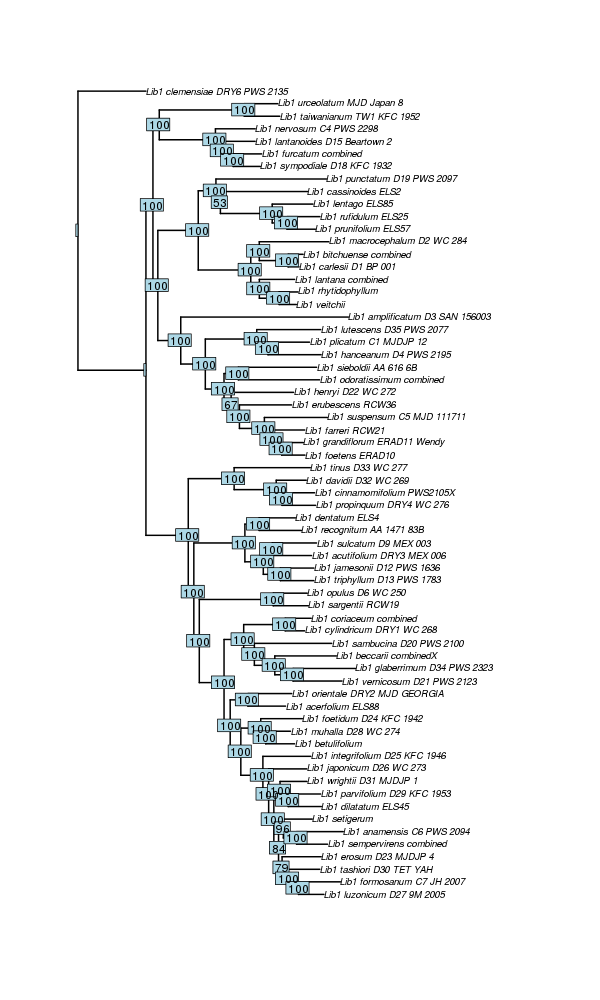

In [132]:
%%R -w 600 -h 1000
library(ape)
tre_half <- read.tree("empirical_1/halfrun/RAxML_bipartitions.empirical_1_halfrun")
#rtre <- root(tre, "Lib1_clemensiae_DRY6_PWS_2135", resolve.root=T)
#rtre <- root(rtre, "Lib1_clemensiae_DRY6_PWS_2135", resolve.root=T)
ltre_half <- ladderize(tre_half)
plot(ltre_half, cex=0.8, edge.width=2)
nodelabels(ltre_half$node.label)

In [6]:
%%R -w 600 -h 1000
library(ape)
svg("outtree.svg", height=11, width=8)
tre_full <- read.tree("empirical_1/fullrun/RAxML_bipartitions.empirical_1_fullrun")
#rtre <- root(tre, "Lib1_clemensiae_DRY6_PWS_2135", resolve.root=T)
#rtre <- root(rtre, "Lib1_clemensiae_DRY6_PWS_2135", resolve.root=T)
ltre_full <- ladderize(tre_full)
plot(ltre_full, cex=0.8, edge.width=3)
#nodelabels(ltre_full$node.label)
dev.off()

png 
  2 


## BUCKY -- write mrbayes nexus blocks for each locus
The functions `nexmake` and `subsample` are used to split the .loci file into individual nexus files for each locus within a new directory. Each nexus file is given a mrbayes command to run. Then we run the bucky tool `mbsum` to summarize the mrbayes output, and finally run `bucky` to infer concordance trees from the posterior distributions of trees across all loci. 

Loci are selected on the basis that they have coverage across all tips of the selected subtree and that they contain at least 1 SNP. 

In [93]:
def nexmake(taxadict, loc, nexdir, trim):
    outloc = open(nexdir+"/"+str(loc)+".nex", 'w')
    header = """
#NEXUS 
begin data;
dimensions ntax={} nchar={};
format datatype=dna interleave=yes missing=N gap=-;
matrix

""".format(len(taxadict), len(taxadict.values()[0]))
    outloc.write(header)
    
    for tax, seq in taxadict.items():
        outloc.write("{}{}{}\n"\
                     .format(tax[trim:trim+9],
                             " "*(10-len(tax[0:9])),
                             "".join(seq)))
    
    mbstring = """
    ;
end;
begin mrbayes;
set autoclose=yes nowarn=yes;
lset nst=6 rates=gamma;
mcmc ngen=2200000 samplefreq=2000;
sump burnin=200000;
sumt burnin=200000;
end;    
"""
    outloc.write(mbstring)
    outloc.close()
    

In [102]:
def unstruct(amb):
    " returns bases from ambiguity code"
    D = {"R":["G","A"],
         "K":["G","T"],
         "S":["G","C"],
         "Y":["T","C"],
         "W":["T","A"],
         "M":["C","A"]}
    if amb in D:
        return D.get(amb)
    else:
        return [amb,amb]
            

def resolveambig(subseq):
    N = []
    for col in subseq:
        N.append([unstruct(i)[np.random.binomial(1, 0.5)] for i in col])
    return np.array(N)

    
def newPIS(seqsamp):
    counts = [Counter(col) for col in seqsamp.T if not ("-" in col or "N" in col)]
    pis = [i.most_common(2)[1][1] > 1 for i in counts if len(i.most_common(2))>1]
    if sum(pis) >= 2:
        return sum(pis)
    else:
        return 0      

In [103]:
def parseloci(iloci, taxadict, nexdir, trim=0):
    nloc = 0
    ## create subsampled data set
    for loc in iloci:
        ## if all tip samples have data in this locus
        names = [line.split()[0] for line in loc.split("\n")[:-1]]

        ## check that locus has required samples for each subtree
        if all([i in names for i in taxadict.values()]):
            seqs = np.array([list(line.split()[1]) for line in loc.split("\n")[:-1]])
            seqsamp = seqs[[names.index(tax) for tax in taxadict.values()]]
            seqsamp = resolveambig(seqsamp)
            pis = newPIS(seqsamp)
            if pis:
                nloc += 1
                ## remove invariable columns given this subsampling
                keep = []
                for n, col in enumerate(seqsamp.T):
                    if all([i not in ["N","-"] for i in col]):
                        keep.append(n)
                subseq = seqsamp.T[keep].T
                ## write to a nexus file
                nexdict = dict(zip(taxadict.keys(), [i.tostring() for i in subseq]))
                nexmake(nexdict, nloc, nexdir, trim)
    print nloc, 'loci kept'            

#### Modify line endings of loci string for easier parsing

In [117]:
def getloci(locifile):
    ## parse the loci file by new line characters
    locifile = open(locifile)
    lines = locifile.readlines()

    ## add "|" to end of lines that contain "|"
    for idx in range(len(lines)):
        if "|" in lines[idx]:
            lines[idx] = lines[idx].strip()+"|\n"
        
    ## join lines back together into one large string
    locistr = "".join(lines)

    ## break string into loci at the "|\n" character
    loci = locistr.split("|\n")[:-1]

    ## how many loci?
    print len(loci), "loci"
    return loci
    
## run on both files
loci_full = getloci("empirical_1/fullrun/outfiles/empirical_1_full_m4.loci")
loci_half = getloci("empirical_1/halfrun/outfiles/empirical_1_half_m4.loci")

199094 loci
143948 loci


### Make nexus files

In [118]:
parseloci(loci_full[:], deep_dict_f, "deep_dict_full", 0)
parseloci(loci_half[:], deep_dict_h, "deep_dict_half", 0)
#parseloci(loci[:], shallow_dict, "shallow_dict", 0)

744 loci kept
71 loci kept


In [119]:
## create a parallel client
ipclient = ipyparallel.Client()
lview = ipclient.load_balanced_view()

## call function across all engines
def mrbayes(infile):
    import subprocess
    cmd = "mb %s" % infile
    subprocess.check_call(cmd, shell=True)

In [120]:
## submit all nexus files to run mb
allnex = glob.glob("deep_dict_full/*.nex")
for nex in allnex:
    lview.apply(mrbayes, nex)

ipclient.wait_interactive()

 744/744 tasks finished after 3759 s
done


### Summarize posteriors with `mbsum`

In [126]:
def mbsum(nexdir, nloci):     
    import subprocess
    ## combine trees from the two replicate runs
    for n in range(1, nloci+1):
        cmd = "mbsum -n 101 -o {}{}.in {}{}.nex.run1.t {}{}.nex.run2.t".\
              format(nexdir, n, nexdir, n, nexdir, n)
        subprocess.check_call(cmd, shell=True)

### Run Bucky to infer concordance factors

In [3]:
import os
import numpy as np
from collections import Counter


def subsample(infile, requires, outgroup, nexdir, trim):
    """ sample n taxa from infile to create nex file"""
    ## counter
    loc = 0
    
    ## create output directory
    if not os.path.exists(nexdir):
        os.mkdir(nexdir)
    
    ## input .alleles file
    loci = open(infile, 'r').read().strip().split("//")
    
    ## create a dictionary of {names:seqs}
    for locus in xrange(len(loci)):
        locnex = [""]*len(requires)
        for line in loci[locus].strip().split("\n"):
            tax = line.split()[0]
            seq = line.split()[-1]
            if ">" in tax:
                if tax in requires:
                    locnex[requires.index(tax)] = seq
        ## if all tips
        if len([i for i in locnex if i]) == len(requires):
            ## if locus is variable
            ## count how many times each char occurs in each site
            ccs = [Counter(i) for i in np.array([list(i) for i in locnex]).T]
            ## remove N and - characters and the first most occurring base
            for i in ccs:
                del i['-']
                del i['N']
                if i:
                    del i[i.most_common()[0][0]]
                
            ## is anything left occuring more than once (minor allele=ma)?
            ma = max([max(i.values()) if i else 0 for i in ccs])
            if ma > 1:
                nexmake(requires, locnex, loc, outgroup, nexdir, trim)
                loc += 1
    
    return loc

### Subtree 1 (Oreinodentinus) (full data set)


In [162]:
## inputs
requires = [">triphyllum_D13_PWS_1783_0", 
            ">jamesonii_D12_PWS_1636_0",
            ">sulcatum_D9_MEX_003_0",
            ">acutifolium_DRY3_MEX_006_0",
            ">dentatum_ELS4_0",
            ">recognitum_AA_1471_83B_0"]
outgroup = ""
infile = "empirical_1/fullrun/outfiles/empirical_1_full_m4.alleles"
nexdir = "nex_files1"

## run function
nloci = subsample(infile, requires, outgroup, nexdir, trim=1)
print nloci

3300


### Subtree 1 (Oreinodentinus) (half data set)


In [161]:
## inputs
requires = [">Lib1_triphyllum_D13_PWS_1783_0", 
            ">Lib1_jamesonii_D12_PWS_1636_0",
            ">Lib1_sulcatum_D9_MEX_003_0",
            ">Lib1_acutifolium_DRY3_MEX_006_0",
            ">Lib1_dentatum_ELS4_0",
            ">Lib1_recognitum_AA_1471_83B_0"]
outgroup = ""
infile = "empirical_1/halfrun/outfiles/empirical_1_half_m4.alleles"
nexdir = "nex_files2"
## run function

nloci = subsample(infile, requires, outgroup, nexdir, trim=6)
print nloci

364


### Subtree 2 (Urceolata) (full data set)

In [16]:
## inputs
requires = [">clemensiae_DRY6_PWS_2135_0", 
            ">tinus_D33_WC_277_0",
            ">taiwanianum_TW1_KFC_1952_0",
            ">lantanoides_D15_Beartown_2_0",
            ">amplificatum_D3_SAN_156003_0",
            ">lutescens_D35_PWS_2077_0",
            ">lentago_ELS85_0",
            ">dentatum_ELS4_0"]
outgroup = ""
infile = "empirical_1/fullrun/outfiles/empirical_1_full_m4.alleles"
nexdir = "nex_files5"

## run function
nloci = subsample(infile, requires, outgroup, nexdir, trim=1)
print nloci

1203


### Subtree 2 (Urceolata) (half data set)

In [17]:
## inputs
requires = [">Lib1_clemensiae_DRY6_PWS_2135_0", 
            ">Lib1_tinus_D33_WC_277_0",
            ">Lib1_taiwanianum_TW1_KFC_1952_0",
            ">Lib1_lantanoides_D15_Beartown_2_0",
            ">Lib1_amplificatum_D3_SAN_156003_0",
            ">Lib1_lutescens_D35_PWS_2077_0",
            ">Lib1_lentago_ELS85_0",
            ">Lib1_dentatum_ELS4_0"]
outgroup = ""
infile = "empirical_1/halfrun/outfiles/empirical_1_half_m4.alleles"
nexdir = "nex_files6"

## run function
nloci = subsample(infile, requires, outgroup, nexdir, trim=6)
print nloci

106


### Run mrbayes on all nex files

In [19]:
import ipyparallel
import subprocess
import glob

## create a parallel client
ipclient = ipyparallel.Client()
lview = ipclient.load_balanced_view()

## call function across all engines
def mrbayes(infile):
    import subprocess
    cmd = "mb %s" % infile
    subprocess.check_call(cmd, shell=True)

In [164]:
## run on the full data set
res = lview.map_async(mrbayes, glob.glob("nex_files1/*"))
_ = res.get()

## run on the half data set
res = lview.map_async(mrbayes, glob.glob("nex_files2/*"))
_ = res.get()

In [72]:
## run on the half data set
res = lview.map_async(mrbayes, glob.glob("nex_files3/*"))
_ = res.get()

## run on the half data set
res = lview.map_async(mrbayes, glob.glob("nex_files4/*"))
_ = res.get()

In [20]:
## run on the half data set
res = lview.map_async(mrbayes, glob.glob("nex_files5/*"))
_ = res.get()

## run on the half data set
res = lview.map_async(mrbayes, glob.glob("nex_files6/*"))
_ = res.get()

### Run mbsum to summarize the results

In [21]:
import os
import subprocess

def mbsum(nexdir, nloci):
    ## create dir for bucky input files
    insdir = os.path.join(nexdir, "ins")
    if not os.path.exists(insdir):  
        os.mkdir(insdir)
                  
    ## combine trees from the two replicate runs
    for n in range(nloci):
        cmd = "mbsum -n 101 -o {}/{}.in {}{}.nex.run1.t {}{}.nex.run2.t".\
              format(insdir, n, nexdir, n, nexdir, n)
        subprocess.check_call(cmd, shell=True)
                          
#mbsum("nex_files1/", 3300)
#mbsum("nex_files2/", 364)
#mbsum("nex_files3/", 1692)
#mbsum("nex_files4/", 169)
mbsum("nex_files5/", 1203)
mbsum("nex_files6/", 106)

### Run Bucky

In [22]:
args = []
for insdir in ["nex_files5/ins", "nex_files6/ins"]:
    ## independence test
    args.append("bucky --use-independence-prior -k 4 -n 500000 \
                -o {}/BUCKY.ind {}/*.in".format(insdir, insdir))   
    ## alpha at three levels
    for alpha in [0.1, 1, 10]:
        args.append("bucky -a {} -k 4 -n 500000 -c 4 -o {}/BUCKY.{} {}/*.in".\
                    format(alpha, insdir, alpha, insdir))
        
    
def bucky(arg):
    import subprocess
    subprocess.check_call(arg, shell=True)
    return arg
    
res = lview.map_async(bucky, args)
res.get()

['bucky --use-independence-prior -k 4 -n 500000                 -o nex_files5/ins/BUCKY.ind nex_files5/ins/*.in',
 'bucky -a 0.1 -k 4 -n 500000 -c 4 -o nex_files5/ins/BUCKY.0.1 nex_files5/ins/*.in',
 'bucky -a 1 -k 4 -n 500000 -c 4 -o nex_files5/ins/BUCKY.1 nex_files5/ins/*.in',
 'bucky -a 10 -k 4 -n 500000 -c 4 -o nex_files5/ins/BUCKY.10 nex_files5/ins/*.in',
 'bucky --use-independence-prior -k 4 -n 500000                 -o nex_files6/ins/BUCKY.ind nex_files6/ins/*.in',
 'bucky -a 0.1 -k 4 -n 500000 -c 4 -o nex_files6/ins/BUCKY.0.1 nex_files6/ins/*.in',
 'bucky -a 1 -k 4 -n 500000 -c 4 -o nex_files6/ins/BUCKY.1 nex_files6/ins/*.in',
 'bucky -a 10 -k 4 -n 500000 -c 4 -o nex_files6/ins/BUCKY.10 nex_files6/ins/*.in']

#### Cleanup

In [ ]:
del lbview
ipclient.close()

### check out the results

In [1]:
%%bash
head -n 40 nex_files1/ins/BUCKY.0.1.concordance


head: cannot open ‘nex_files1/ins/BUCKY.0.1.concordance’ for reading: No such file or directory


In [186]:
%%bash
head -n 40 nex_files1/ins/BUCKY.1.concordance


translate
 1 triphyllu,
 2 jamesonii,
 3 sulcatum_,
 4 acutifoli,
 5 dentatum_,
 6 recognitu;

Population Tree:
(((1,2),(3,4)),5,6);

Primary Concordance Tree Topology:
(((1,2),(3,4)),5,6);

Population Tree, With Branch Lengths In Estimated Coalescent Units:
(((1:10.000,2:10.000):0.478,(3:10.000,4:10.000):0.156):0.840,5:10.000,6:10.000);

Primary Concordance Tree with Sample Concordance Factors:
(((1:1.000,2:1.000):0.562,(3:1.000,4:1.000):0.351):0.591,5:1.000,6:1.000);

Four-way partitions in the Population Tree: sample-wide CF, coalescent units and Ties(if present)
{1; 2|3,4; 5,6}	0.586, 0.478,  
{1,2; 5,6|3; 4}	0.429, 0.156,  
{1,2; 3,4|5; 6}	0.712, 0.840,  

Splits in the Primary Concordance Tree: sample-wide and genome-wide mean CF (95% credibility), SD of mean sample-wide CF across runs
{1,2,3,4|5,6} 0.591(0.562,0.621) 0.591(0.557,0.625)	0.001
{1,2|3,4,5,6} 0.562(0.533,0.586) 0.562(0.529,0.592)	0.001
{1,2,5,6|3,4} 0.351(0.320,0.383) 0.351(0.316,0.387)	0.001

Splits NOT in the Prim

In [185]:
%%bash
head -n 40 nex_files2/ins/BUCKY.1.concordance


translate
 1 _triphyll,
 2 _jamesoni,
 3 _sulcatum,
 4 _acutifol,
 5 _dentatum,
 6 _recognit;

Population Tree:
((((1,2),3),4),5,6);

Primary Concordance Tree Topology:
(((1,2),(3,4)),5,6);

Population Tree, With Branch Lengths In Estimated Coalescent Units:
((((1:10.000,2:10.000):0.315,3:10.000):0.080,4:10.000):0.540,5:10.000,6:10.000);

Primary Concordance Tree with Sample Concordance Factors:
(((1:1.000,2:1.000):0.389,(3:1.000,4:1.000):0.293):0.378,5:1.000,6:1.000);

Four-way partitions in the Population Tree: sample-wide CF, coalescent units and Ties(if present)
{1; 2|3; 4,5,6}	0.513, 0.315,  
{1,2,3; 4|5; 6}	0.612, 0.540,  
{1,2; 3|4; 5,6}	0.385, 0.080,  

Splits in the Primary Concordance Tree: sample-wide and genome-wide mean CF (95% credibility), SD of mean sample-wide CF across runs
{1,2|3,4,5,6} 0.389(0.308,0.470) 0.389(0.295,0.484)	0.003
{1,2,3,4|5,6} 0.378(0.294,0.467) 0.377(0.280,0.480)	0.002
{1,2,5,6|3,4} 0.293(0.206,0.393) 0.292(0.196,0.402)	0.006

Splits NOT in the Prim

In [2]:
! head -n 45 nex_files3/ins/BUCKY.0.1.concordance


translate
 1 clemensia,
 2 davidii_D,
 3 taiwanian,
 4 lantanoid,
 5 amplifica,
 6 lutescens,
 7 carlesii_,
 8 dentatum_;

Population Tree:
((1,(3,(4,((5,6),7)))),2,8);

Primary Concordance Tree Topology:
((1,((3,4),((5,6),7))),2,8);

Population Tree, With Branch Lengths In Estimated Coalescent Units:
((1:10.000,(3:10.000,(4:10.000,((5:10.000,6:10.000):0.968,7:10.000):0.092):0.029):0.134):2.022,2:10.000,8:10.000);

Primary Concordance Tree with Sample Concordance Factors:
((1:1.000,((3:1.000,4:1.000):0.201,((5:1.000,6:1.000):0.660,7:1.000):0.175):0.181):0.877,2:1.000,8:1.000);

Four-way partitions in the Population Tree: sample-wide CF, coalescent units and Ties(if present)
{1,2,3,4,8; 7|5; 6}	0.747, 0.968,  
{1; 3,4,5,6,7|2; 8}	0.912, 2.022,  
{1; 2,8|3; 4,5,6,7}	0.417, 0.134,  
{1,2,3,8; 4|5,6; 7}	0.392, 0.092,  
{1,2,8; 3|4; 5,6,7}	0.353, 0.029,  

Splits in the Primary Concordance Tree: sample-wide and genome-wide mean CF (95% credibility), SD of mean sample-wide CF across runs
{1,

### FINAL BUCKY RESULTS (DEEP_SCALE)

In [3]:
! head -n 45 nex_files4/ins/BUCKY.0.1.concordance


translate
 1 clemensia,
 2 davidii_D,
 3 taiwanian,
 4 lantanoid,
 5 amplifica,
 6 lutescens,
 7 carlesii_,
 8 dentatum_;

Population Tree:
((1,(3,((4,(5,6)),7))),2,8);

Primary Concordance Tree Topology:
((1,((3,(4,(5,6))),7)),2,8);

Population Tree, With Branch Lengths In Estimated Coalescent Units:
((1:10.000,(3:10.000,((4:10.000,(5:10.000,6:10.000):0.946):0.054,7:10.000):0.057):0.220):1.283,2:10.000,8:10.000);

Primary Concordance Tree with Sample Concordance Factors:
((1:1.000,((3:1.000,(4:1.000,(5:1.000,6:1.000):0.660):0.180):0.171,7:1.000):0.270):0.744,2:1.000,8:1.000);

Four-way partitions in the Population Tree: sample-wide CF, coalescent units and Ties(if present)
{1,2,3,7,8; 4|5; 6}	0.741, 0.946,  
{1; 3,4,5,6,7|2; 8}	0.815, 1.283,  
{1; 2,8|3; 4,5,6,7}	0.465, 0.220,  
{1,2,3,8; 7|4; 5,6}	0.368, 0.054,  
{1,2,8; 3|4,5,6; 7}	0.370, 0.057,  

Splits in the Primary Concordance Tree: sample-wide and genome-wide mean CF (95% credibility), SD of mean sample-wide CF across runs
{1,

In [23]:
! head -n 45 nex_files5/ins/BUCKY.0.1.concordance


translate
 1 clemensia,
 2 tinus_D33,
 3 taiwanian,
 4 lantanoid,
 5 amplifica,
 6 lutescens,
 7 lentago_E,
 8 dentatum_;

Population Tree:
((1,((3,4),((5,6),7))),2,8);

Primary Concordance Tree Topology:
((1,((3,4),((5,6),7))),2,8);

Population Tree, With Branch Lengths In Estimated Coalescent Units:
((1:10.000,((3:10.000,4:10.000):0.067,((5:10.000,6:10.000):0.776,7:10.000):0.158):0.199):1.736,2:10.000,8:10.000);

Primary Concordance Tree with Sample Concordance Factors:
((1:1.000,((3:1.000,4:1.000):0.186,((5:1.000,6:1.000):0.619,7:1.000):0.181):0.228):0.844,2:1.000,8:1.000);

Four-way partitions in the Population Tree: sample-wide CF, coalescent units and Ties(if present)
{1; 3,4,5,6,7|2; 8}	0.883, 1.736,  
{1,2,3,4,8; 7|5; 6}	0.693, 0.776,  
{1; 2,8|3,4; 5,6,7}	0.454, 0.199,  
{1,2,8; 3,4|5,6; 7}	0.431, 0.158,  
{1,2,8; 5,6,7|3; 4}	0.377, 0.067,  

Splits in the Primary Concordance Tree: sample-wide and genome-wide mean CF (95% credibility), SD of mean sample-wide CF across runs
{1,

In [24]:
! head -n 45 nex_files6/ins/BUCKY.0.1.concordance


translate
 1 clemensia,
 2 tinus_D33,
 3 taiwanian,
 4 lantanoid,
 5 amplifica,
 6 lutescens,
 7 lentago_E,
 8 dentatum_;

Population Tree:
((1,((3,4),((5,6),7))),2,8);

Primary Concordance Tree Topology:
((1,((3,4),((5,6),7))),2,8);

Population Tree, With Branch Lengths In Estimated Coalescent Units:
((1:10.000,((3:10.000,4:10.000):0.060,((5:10.000,6:10.000):0.654,7:10.000):0.279):0.385):1.135,2:10.000,8:10.000);

Primary Concordance Tree with Sample Concordance Factors:
((1:1.000,((3:1.000,4:1.000):0.164,((5:1.000,6:1.000):0.564,7:1.000):0.327):0.288):0.706,2:1.000,8:1.000);

Four-way partitions in the Population Tree: sample-wide CF, coalescent units and Ties(if present)
{1,2,3,4,8; 7|5; 6}	0.653, 0.654,  
{1; 3,4,5,6,7|2; 8}	0.786, 1.135,  
{1,2,8; 3,4|5,6; 7}	0.496, 0.279,  
{1; 2,8|3,4; 5,6,7}	0.547, 0.385,  
{1,2,8; 5,6,7|3; 4}	0.372, 0.060,  

Splits in the Primary Concordance Tree: sample-wide and genome-wide mean CF (95% credibility), SD of mean sample-wide CF across runs
{1,

### Get missing data percentatge for m2 data sets 
For this I start raxml to get the info and then quit. Kind of lazy but simpler than calculating it myself.

In [ ]:
%%bash
## raxml argumement w/ ...
raxmlHPC-PTHREADS-AVX -f a -m GTRGAMMA -N 100 -x 12345 -p 12345 -T 20 \
                      -w /home/deren/Documents/RADmissing/empirical_1/fullrun \
                      -n empirical_1_full_m2 -s empirical_1/fullrun/outfiles/empirical_1_m2.phy
                      

In [27]:
%%bash 
head -n 20 empirical_1/fullrun/RAxML_info.empirical_1_full_m2



This is RAxML version 8.0.16 released by Alexandros Stamatakis on March 21 2014.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
David Dao         (KIT)
Charlie Taylor    (UF)


Alignment has 502491 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 88.66%

RAxML rapid bootstrapping and subsequent ML search


### Get average phylo dist (GTRgamma dist)

In [37]:
%%R
mean(cophenetic.phylo(ltre))

[1] 0.06114884
